In [1]:
DRIVE = False

In [2]:
# Pour que les changements dans les modules importés soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

# permet d'obtenir le temps d'exécution de chacune des cellules du notebook
! pip install ipython-autotime
%load_ext autotime

In [3]:
if DRIVE:
    import os
    from google.colab import drive
    drive.mount('drive')
    os.chdir('drive/My Drive/univ/master-2/reinforcement-learning/3-mcts')

time: 698 µs


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from games import OthelloState
from uct import uct_search
from mcrave import rave_search

time: 4.98 ms


# 1. Evolution de la performance en fonction du nombre de noeuds de l'exploration, $Q_{baseline}$ vs $Q_{baseline}$

In [7]:
def play_uct_baseline_vs_uct_baseline(player_1_iter, player_2_iter):
    """
    Play a sample game between two uct players where each player gets a
    different number of uct iterations (= simulations = tree nodes).
    """
    state = OthelloState()

    while len(state.get_moves()) > 0:
        if state.player_just_moved == 1:
            # player 1 just moved, it's player's 2 turn
            m = uct_search(root_state=state,
                           iter_max=player_2_iter,
                           heuristic=None,
                           verbose=False)
        else:
            m = uct_search(root_state=state,
                           iter_max=player_1_iter,
                           heuristic=None,
                           verbose=False)
        
        state.do_move(m)
    
    # get results from player 2 view (the challenger)
    if state.get_result(state.player_just_moved) == 1.0:
        # the last player that moved won
        return 0 if state.player_just_moved == 1 else 1
    elif state.get_result(state.player_just_moved) == 0.0:
        # the last player that moved lost
        return 1 if state.player_just_moved == 1 else 0
    else:
        return 0.5

time: 2.27 ms


## Simulation sans parallélisation

In [14]:
# profondeur d'exploration de UCT
depth_baseline = 20
depth_challengers = [1, 5, 20, 80, 400] # 1/20, 1/4, 1/1, 4/1, 20/1

# nombre de simulations et performance moyenne pour chacune des profondeurs
simulations = 10
performances = np.zeros(len(depth_challengers))

# simulons !
for depth_idx, depth_val in enumerate(depth_challengers):
    for _ in range(simulations):
        performances[depth_idx] += play_uct_baseline_vs_uct_baseline(depth_baseline,
                                                                     depth_val)
    
    performances[depth_idx] /= simulations
    print(f"{depth_challengers[depth_idx]} vs {depth_baseline} => {performances[depth_idx]}")

1 vs 20 => 0.0
5 vs 20 => 0.1
20 vs 20 => 0.6
80 vs 20 => 0.8
400 vs 20 => 1.0
time: 16min 53s


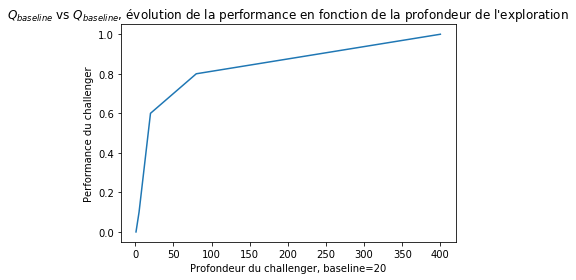

time: 348 ms


In [15]:
plt.plot(depth_challengers, performances)
plt.xlabel(f"Profondeur du challenger, baseline={depth_baseline}")
plt.ylabel("Performance du challenger")
plt.title("$Q_{baseline}$ vs $Q_{baseline}$, évolution de la performance en fonction de la profondeur de l'exploration")
plt.show()

## Simulation avec parallélisation

In [16]:
"""
num_cpus = psutil.cpu_count(logical=False)
pool = Pool(num_cpus)

def myfunc(a, b):
    return [uct_play_game(baseline, i) for i in to_test]

results = pool.starmap(myfunc, [(1, 1) for i in range(simulations)])
"""

'\nnum_cpus = psutil.cpu_count(logical=False)\npool = Pool(num_cpus)\n\ndef myfunc(a, b):\n    return [uct_play_game(baseline, i) for i in to_test]\n\nresults = pool.starmap(myfunc, [(1, 1) for i in range(simulations)])\n'

time: 2.25 ms


# 2. Evaluation de la stratégie $Q_{even}$ vs $Q_{baseline}$, à nombre de noeuds d'exploration égal

In [8]:
def play_uct_baseline_vs_uct_even(player_1_iter, player_2_iter):
    """
    Play a sample game between two uct players where each player gets a
    different number of uct iterations (= simulations = tree nodes).
    """
    state = OthelloState()

    while len(state.get_moves()) > 0:
        if state.player_just_moved == 1:
            # player 1 just moved, it's player's 2 turn
            m = uct_search(root_state=state,
                           iter_max=player_2_iter,
                           heuristic="even",
                           verbose=False)
        else:
            m = uct_search(root_state=state,
                           iter_max=player_1_iter,
                           heuristic=None,
                           verbose=False)
        
        state.do_move(m)
    
    # get results from player 2 view (the challenger)
    if state.get_result(state.player_just_moved) == 1.0:
        # the last player that moved won
        return 0 if state.player_just_moved == 1 else 1
    elif state.get_result(state.player_just_moved) == 0.0:
        # the last player that moved lost
        return 1 if state.player_just_moved == 1 else 0
    else:
        return 0.5

time: 3.52 ms


## Simulation sans parallélisation

In [9]:
depth = 20
simulations = 50

perf_baseline = np.zeros(simulations)
perf_even = np.zeros(simulations)

# simulons !
for simulation_idx in range(simulations):
    print(f"{simulation_idx+1}.", end="")
    perf_baseline[simulation_idx] = play_uct_baseline_vs_uct_baseline(depth, depth)
    perf_even[simulation_idx] = play_uct_baseline_vs_uct_even(depth, depth)

print()
perf_baseline_sum = perf_baseline.sum()
perf_even_sum = perf_even.sum()

print(f"depth = {depth}, simulations = {simulations}")
print(f"performance baseline = {perf_baseline_sum / simulations}")
print(f"performance even     = {perf_even_sum / simulations}")

1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.
depth = 20, simulations = 50
performance baseline = 0.51
performance even     = 0.49
time: 11min 56s


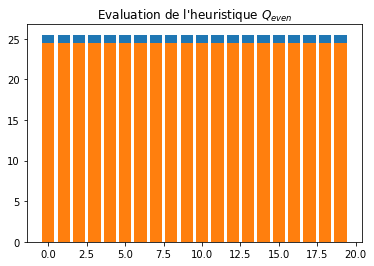

time: 393 ms


In [10]:
plt.bar(np.arange(20), perf_baseline_sum, label="$Q_{baseline}$ vs $Q_{baseline}$")
plt.bar(np.arange(20), perf_even_sum, label="$Q_{baseline}$ vs $Q_{even}$")
plt.title("Evaluation de l'heuristique $Q_{even}$")
plt.show()

# 3. Evaluation de la stratégie $Q_{grandfather}$ vs $Q_{baseline}$, à nombre de noeuds d'exploration égal

In [26]:
def uct_grandfather_search(root_state, iter_max, verbose=False):
    """
    Conduct a uct search for itermax iterations starting from rootstate.
    Return the best move from the rootstate.
    Assumes 2 alternating players (player 1 starts), with game results in the
    range [0.0, 1.0].
    """
    print('grandfather search...')
    
    rootnode = Node(state=root_state)

    for i in range(iter_max):
        print(i)
        
        node = rootnode
        state = root_state.clone()

        # Select
        # node is fully expanded and non-terminal
        while node.untried_moves == [] and node.childNodes != []:
            node = node.uct_select_child()
            state.do_move(node.move)
            print('select mode')

        # Expand
        # if we can expand (i.e. state/node is non-terminal)
        if len(node.untried_moves) > 0:
            m = random.choice(node.untried_moves)
            state.do_move(m)
            node = node.add_child(m, state)  # add child and descend tree
            node.use_heuristic_grandfather()
            print('expand mode')

        # Rollout - this can often be made orders of magnitude quicker using a
        # state.GetRandomMove() function
        while len(state.get_moves()) > 0:  # while state is non-terminal
            state.do_move(random.choice(state.get_moves()))
            print('rollout mode')

        # Backpropagate
        # backpropagate from the expanded node and work back to the root node
        while node is not None:
            # state is terminal. update node with result from POV of
            # node.player_just_moved
            node.update(state.get_result(node.player_just_moved))
            node = node.parentNode
            print('backpropagate mode')
            
        print('-' * 50)

    # return the move that was most visited
    return sorted(rootnode.childNodes, key=lambda c: c.visits)[-1].move


def uct_baseline_vs_grandfather(iter_max_for_both):
    """
    Play a sample game between a basline uct player and a uct player
    with Q_grandfather heuristic.
    Both players have the same number of nodes to explore.
    """
    state = OthelloState()
    
    while len(state.get_moves()) > 0:
        if state.player_just_moved == 1:
            # Player 2 is the challenger
            m = uct_grandfather_search(root_state=state,
                                       iter_max=iter_max_for_both,
                                       verbose=False)
        else:
            # Player 1 is the actual champion
            m = uct_baseline_search(root_state=state,
                                    iter_max=iter_max_for_both,
                                    verbose=False)
        
        state.do_move(m)

    # get results from player 2 view (the challenger)
    if state.get_result(state.player_just_moved) == 1.0:
        # the last player that moved won
        return 0 if state.player_just_moved == 1 else 1
    elif state.get_result(state.player_just_moved) == 0.0:
        # the last player that moved lost
        return 1 if state.player_just_moved == 1 else 0
    else:
        return 0.5

time: 3.53 ms


## Simulation sans parallélisation

In [27]:
depth = 20
simulations = 1

perf_baseline = np.zeros(simulations)
perf_grandfather = np.zeros(simulations)

# simulons !
for simulation_idx in range(simulations):
    print(f"{simulation_idx+1}/{simulations} ... ")
    
    # perf_baseline[simulation_idx] = uct_baseline_vs_baseline(depth, depth)
    perf_grandfather[simulation_idx] = uct_baseline_vs_grandfather(depth)

1/1 ... 
grandfather search...
0
expand mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
backpropagate mode
backpropagate mode
--------------------------------------------------
1
expand mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout mode
rollout

In [28]:
perf_baseline_sum = perf_baseline.sum()
perf_grandfather_sum = perf_grandfather.sum()

print(f"depth = {depth}, simulations = {simulations}")
print(f"performance baseline    = {perf_baseline_sum / simulations}")
print(f"performance grandfather = {perf_grandfather_sum / simulations}")

depth = 20, simulations = 1
performance baseline    = 0.0
performance grandfather = 0.0
time: 1.02 ms
